Heróis compartilhados: 38
Aparições repetidas: 12
Top 5 heróis mais frequentes: ['Rubick', 'Ember Spirit', 'Void Spirit', 'Mars', 'Phoenix']


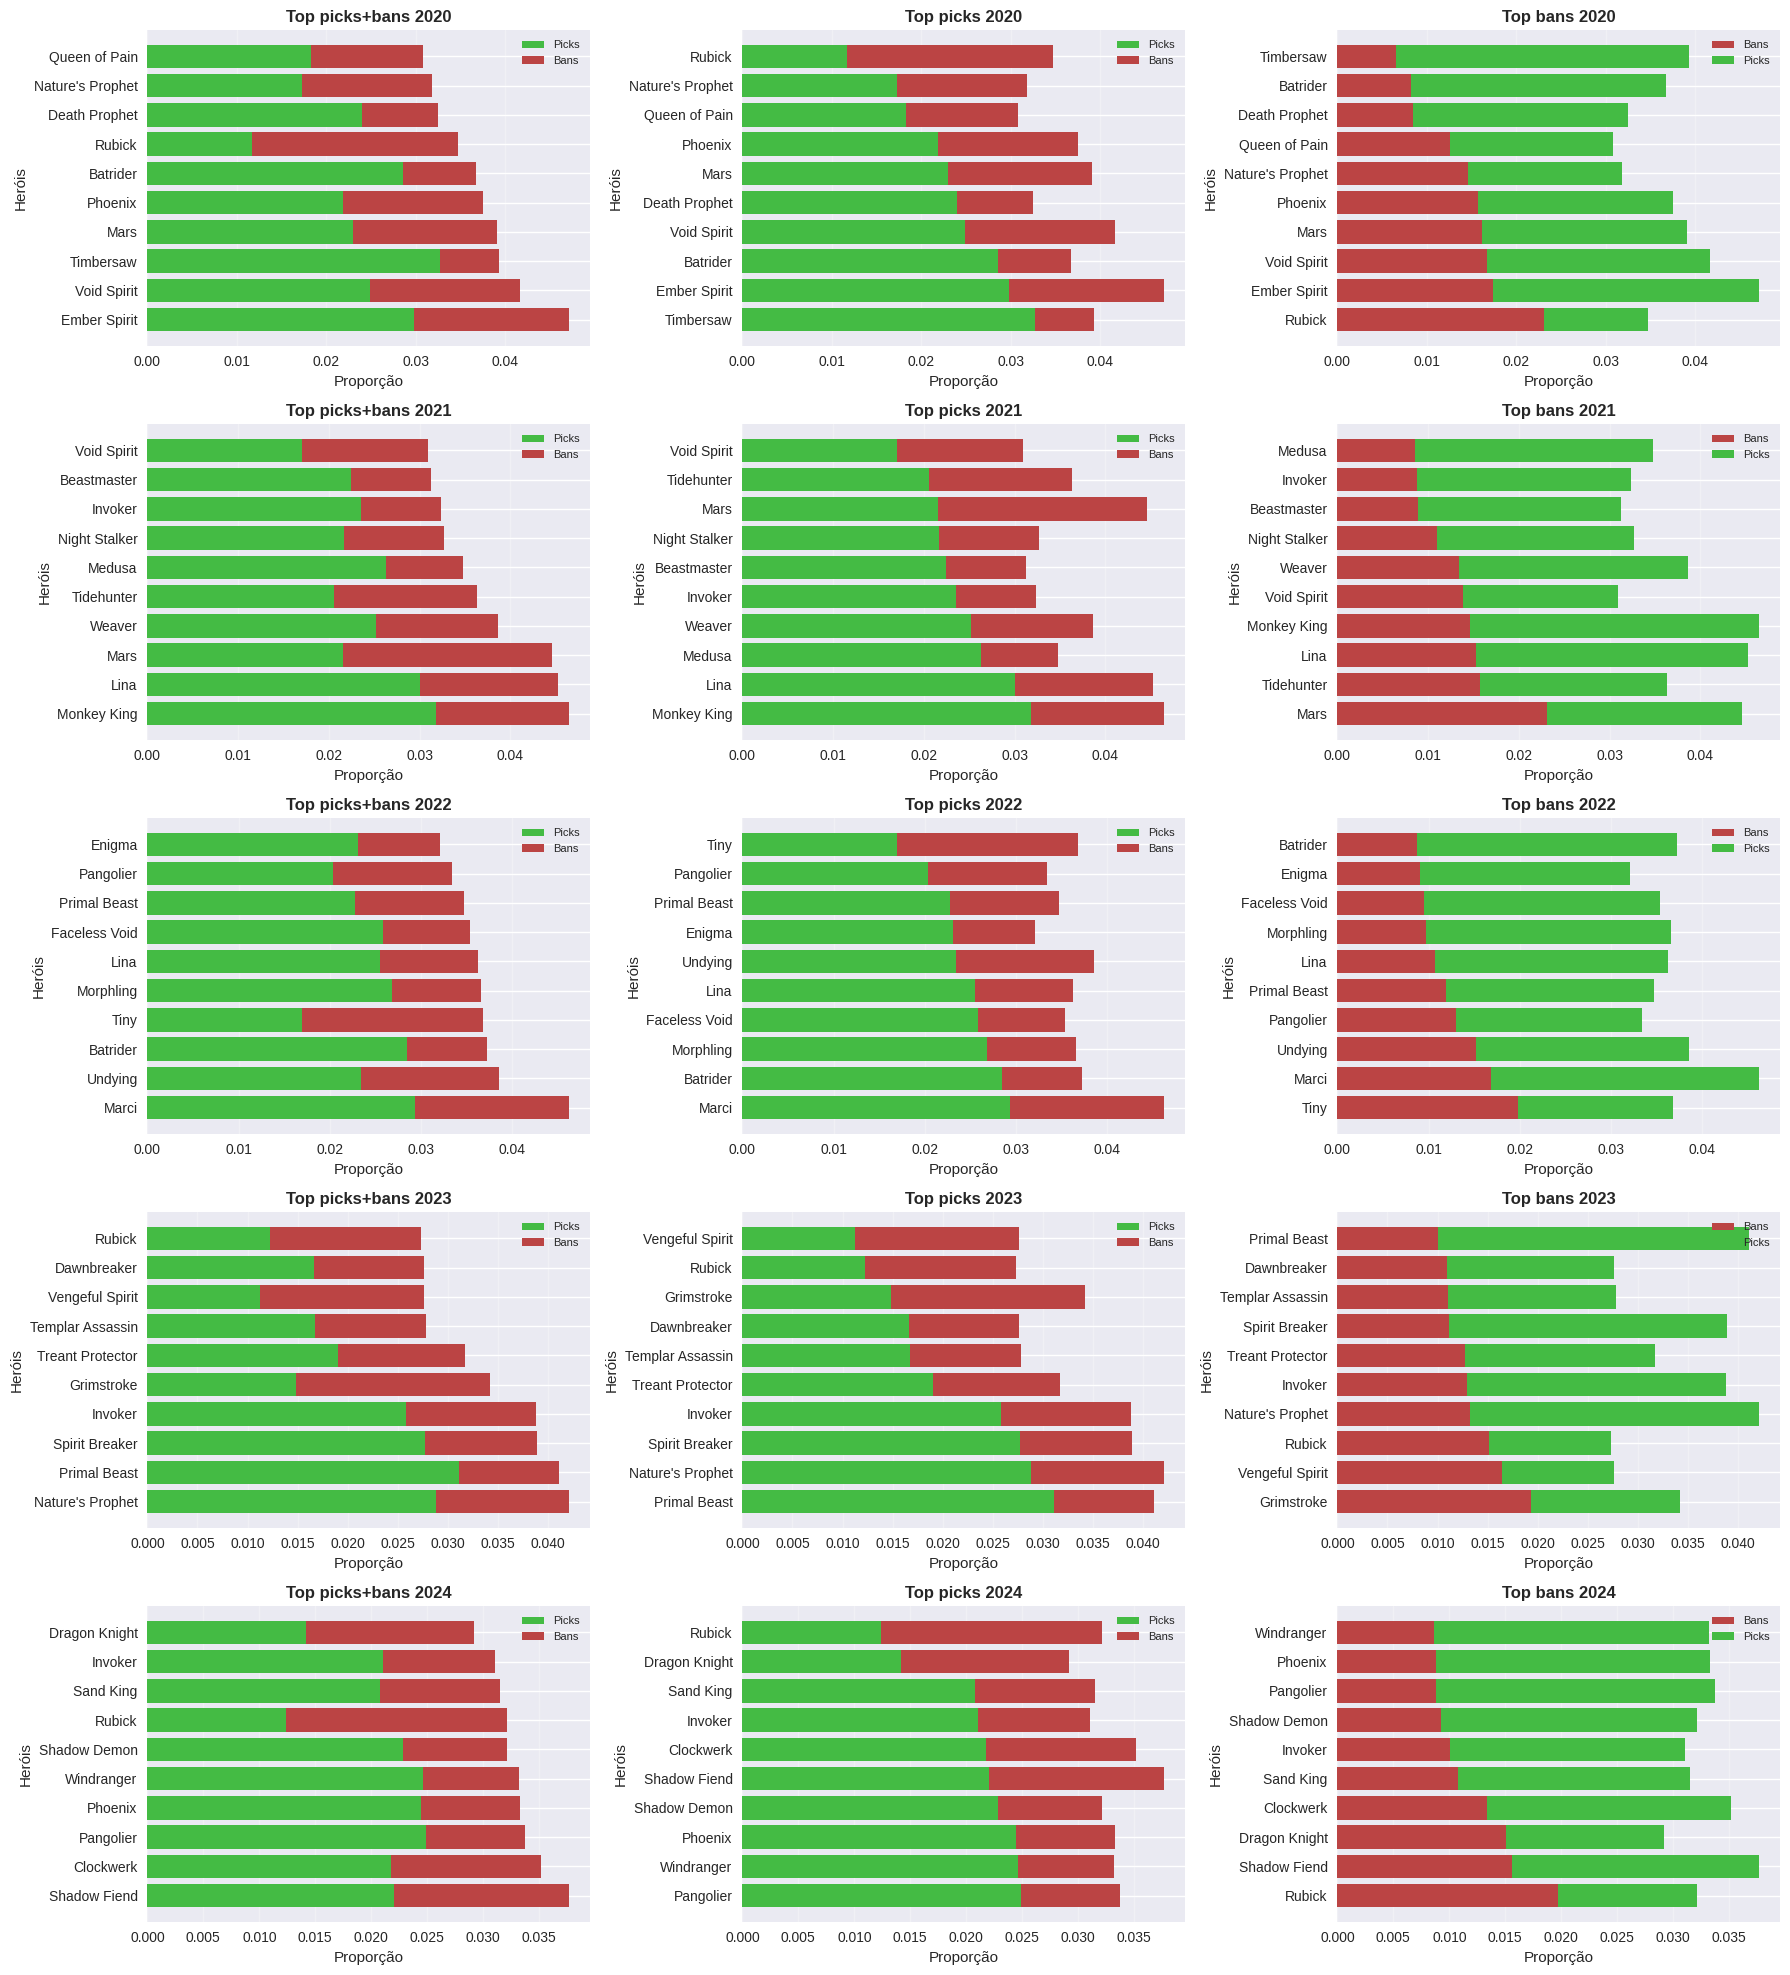

In [5]:
import numpy as np
from dota import Dota2
from dota import Dataset
import polars as pl
from dota import plotter, plotter_3col

dataset = Dataset()
lf = dataset.get_year(2023)
most_played = []
stacked_datasets = []

for year in range(2020, 2025):
    usage = dataset.get_heroes_usage(year)
    df_usage = usage.collect()
    hero_usage = (
        df_usage
        .group_by(["hero_id"])
        .agg([
            pl.when(pl.col("pick") == True).then(
                pl.lit(1)).count().alias("picks"),
            pl.when(pl.col("pick") == False).then(
                pl.lit(1)).count().alias("bans"),
            pl.col("hero_name").first().alias("name")
        ])
    )
    heroes: np.ndarray = np.empty((0, 3))
    for _heroes in hero_usage.iter_rows():
        if (_heroes[1] == 0 and _heroes[2] == 0):
            continue
        heroes += [_heroes[0], _heroes[1], _heroes[2]]

    picks_bans = hero_usage.to_numpy()
    # Normalizar antes de plotear
    total = np.sum(heroes[:, 1]) + np.sum(picks_bans[:, 2])
    picks = picks_bans[:, 2] / total
    bans = picks_bans[:, 1] / total
    
    # Selecionar os top 10 pelo total de picks + bans
    top_n = 10
    totals = picks + bans
    top_idx = np.argsort(-totals)[:top_n]
    picks_bans = picks_bans[top_idx]
    picks = picks[top_idx]
    bans = bans[top_idx]

    # Ordenar pelos 3 critérios diferentes
    idx_totals = np.argsort(-(picks + bans))
    idx_picks = np.argsort(-picks)
    idx_bans = np.argsort(-bans)

    # Preparar datasets para stacked bar plots
    # 1. Top picks+bans (picks na base, bans empilhados)
    stacked_datasets.append({
        'categories': picks_bans[idx_totals, 3],
        'y1': picks[idx_totals],
        'y2': bans[idx_totals],
        'colors': ('#44bb44', '#bb4444'),
        'labels': ('Picks', 'Bans'),
        'xlabel': "Heróis",
        'ylabel': "Proporção",
        'title': f"Top picks+bans {year}",
        'show_values': False,
        'horizontal': True,
        'rotation': 0
    })

    # 2. Top picks (picks dominantes, bans menores)
    stacked_datasets.append({
        'categories': picks_bans[idx_picks, 3],
        'y1': picks[idx_picks],
        'y2': bans[idx_picks],
        'colors': ('#44bb44', '#bb4444'),
        'labels': ('Picks', 'Bans'),
        'xlabel': "Heróis",
        'ylabel': "Proporção",
        'title': f"Top picks {year}",
        'show_values': False,
        'horizontal': True,
        'rotation': 0
    })

    # 3. Top bans (bans dominantes, picks menores)
    stacked_datasets.append({
        'categories': picks_bans[idx_bans, 3],
        'y1': bans[idx_bans],
        'y2': picks[idx_bans],
        'colors': ('#bb4444', '#44bb44'),
        'labels': ('Bans', 'Picks'),
        'xlabel': "Heróis",
        'ylabel': "Proporção",
        'title': f"Top bans {year}",
        'show_values': False,
        'horizontal': True,
        'rotation': 0
    })

    most_played.append(
        [picks_bans[idx_bans, 3], picks[idx_picks], bans[idx_bans]])

# Plota todos os anos em subplots de 3 colunas usando stacked bar plots
plotter_3col.multi_stacked_bar_plot(
    datasets=stacked_datasets,
    titles=[d['title'] for d in stacked_datasets],
    figsize=(18, 20),
    overall_title=""
)

# Análise de heróis compartilhados
shared_heroes = {}
shared = []
for hero in most_played:
    for i in range(len(hero[0])):
        if hero[0][i] not in shared_heroes:
            shared_heroes[hero[0][i]] = {
                "picks": 1,
                "bans": 1,
            }
        else:
            shared.append(hero[0][i])
            current_hero = shared_heroes[hero[0][i]]
            current_hero["picks"] += 1
            current_hero["bans"] += 1

print(f"Heróis compartilhados: {len(shared_heroes)}")
print(f"Aparições repetidas: {len(shared)}")
print(f"Top 5 heróis mais frequentes: {list(shared_heroes.keys())[:5]}")